# **Fine-tune VIT multi-label image classification**

## **Set-up environment**

In [1]:
!pip install --upgrade transformers -q
!pip install mlflow==2.7.1 dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing 

In [2]:
import os
import cv2
import random
import torch
import numpy as np

from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

## **Data preprocessing**

In [3]:
#splite the training and testing path

train_size = 0.9
paths = []
path_to_subset = '/kaggle/input/document-dataset-400/train'
for folder in os.listdir(path_to_subset):

    for image in os.listdir(os.path.join(path_to_subset, folder)):
        path_to_image = os.path.join(path_to_subset, folder, image)

        #check image none or not none
        img = cv2.imread(path_to_image)
        if img is not None:
          paths.append( path_to_image)

paths = sorted(paths)
paths[0]
random.shuffle(paths)
assert 0.0 < train_size <= 1.0
thresh = round(len(paths) * train_size)
train_paths = paths[:thresh]
test_paths = paths[thresh:]
print(train_paths[0], test_paths[1])

libpng warning: iCCP: known incorrect sRGB profile


/kaggle/input/document-dataset-400/train/invoice/45.jpg /kaggle/input/document-dataset-400/train/invoice/2028694058.jpg


In [4]:
print("show sample of training path ",train_paths[0:5])
print("Number of training data : ",len(train_paths))
print("Number of val data : ", len(test_paths))

show sample of training path  ['/kaggle/input/document-dataset-400/train/invoice/45.jpg', '/kaggle/input/document-dataset-400/train/note/517304340+-4342.jpg', '/kaggle/input/document-dataset-400/train/form/2028706067.jpg', '/kaggle/input/document-dataset-400/train/advertisement/2042333574.jpg', '/kaggle/input/document-dataset-400/train/invoice/35.jpg']
Number of training data :  1835
Number of val data :  204


In [5]:
#Label and classes extraction
def labels(root):
  classes=[]
  lab=[]
  labels=[]
  for idx in range(len(root)):
    # get image
    image_path =root[idx]

    # get labels
    label = image_path.split(os.path.sep)[-2].split(' ')
    lab.append(label)

  mlb = MultiLabelBinarizer()
  labels = mlb.fit_transform(lab)
  classes = mlb.classes_

  return mlb,labels,classes

In [6]:
#Show label and classes
mlb,m_labels,classes=labels(train_paths)
print("labels encode :",m_labels)
print("Class Names :",classes)

labels encode : [[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]
Class Names : ['advertisement' 'email' 'form' 'invoice' 'note']


In [7]:
#Id to label and label to id for fine tune the model
id2label = {id: label for id, label in enumerate(classes)}
label2id = {v: k for k, v in id2label.items()}
print(id2label)
print(label2id)

{0: 'advertisement', 1: 'email', 2: 'form', 3: 'invoice', 4: 'note'}
{'advertisement': 0, 'email': 1, 'form': 2, 'invoice': 3, 'note': 4}


# Data distribution 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


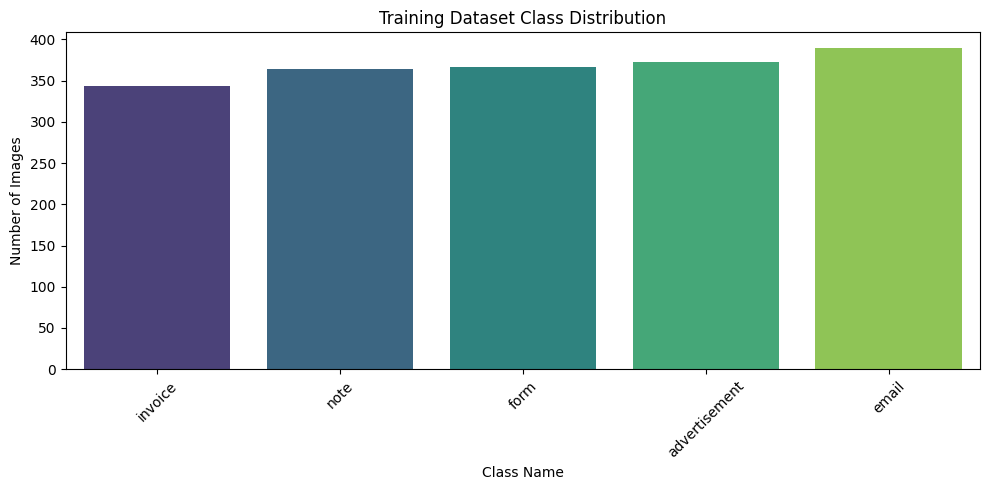

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


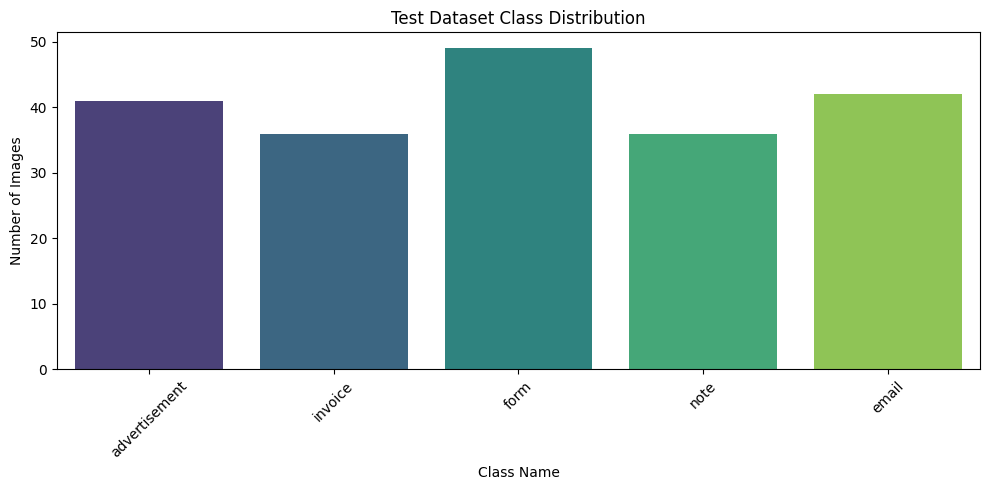

In [8]:


import os
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

def extract_class_names(paths):
    """Extract class names (folder names) from the list of image paths"""
    return [os.path.basename(os.path.dirname(p)) for p in paths]

def plot_class_distribution(paths, title="Class Distribution"):
    class_names = extract_class_names(paths)
    class_counts = Counter(class_names)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title(title)
    plt.xlabel("Class Name")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot training set distribution
plot_class_distribution(train_paths, title="Training Dataset Class Distribution")

# Plot test set distribution
plot_class_distribution(test_paths, title="Test Dataset Class Distribution")


## **Create PyTorch Dataset**

In [9]:
class MultiLabelDataset(Dataset):
  def __init__(self, root, transform,labels):
    self.root = root
    self.transform = transform
    self.labels=labels

    
  def __getitem__(self, idx):
    # get image
    image_path = self.root[idx]
    image = Image.open(image_path).convert("RGB")

    # prepare image for the model
    pixel_values = self.transform(image)

    # get labels
    label = self.labels[idx].astype(np.float32)

    # turn into PyTorch tensor
    label = torch.from_numpy(label)

    return pixel_values,label


  def __len__(self):
    return len(self.root)

## **Model Load**

In [10]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

#select the pretraining model
model_id = "google/vit-base-patch16-224-in21k" # "google/siglip-so400m-patch14-384"

processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(model_id, problem_type="multi_label_classification", id2label=id2label,label2id=label2id)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

2025-06-30 06:51:28.393293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751266288.581721      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751266288.638756      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [11]:
#show processing details in pre training model
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# get appropriate size, mean and std based on the image processor
size = processor.size["height"]
mean = processor.image_mean
std = processor.image_std

transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])


#add the dataset to pytorch dataset
train_dataset = MultiLabelDataset(root=train_paths, transform=transform,labels=m_labels)


## **Show samples**

In [13]:

pixel_values ,labels = train_dataset[12]
print(pixel_values.shape)

torch.Size([3, 224, 224])


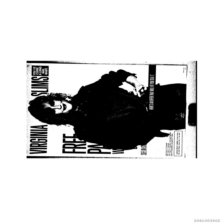

In [14]:


unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [15]:

print("label ID :",labels)
s=torch.nonzero(labels).squeeze().tolist()
print(s)

label ID : tensor([1., 0., 0., 0., 0.])
0


In [16]:
#conver ID to label
[id2label[s]]

['advertisement']

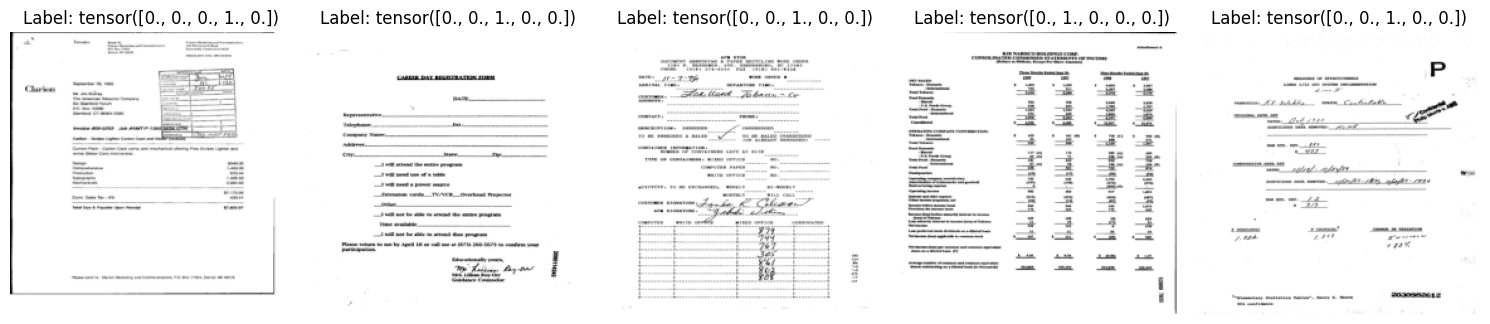

In [17]:
import random
import matplotlib.pyplot as plt

# Sample 5 random indices from your dataset
random_indices = random.sample(range(len(train_dataset)), 5)

# Plot the images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    pixel_values, label = train_dataset[idx]  # assumes this returns (image, label)

    # If pixel_values is a tensor, convert it to numpy
    if hasattr(pixel_values, 'numpy'):
        image = pixel_values.numpy()
    else:
        image = pixel_values

    # If image has shape (channels, height, width), convert to (height, width, channels)
    if image.shape[0] in [1, 3] and len(image.shape) == 3:
        image = image.transpose(1, 2, 0)

    # Clip or normalize image if needed (for display)
    image = image.squeeze()
    image = image - image.min()
    image = image / image.max()

    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap="gray" if image.ndim == 2 else None)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Create PyTorch DataLoader**

In [18]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.stack([item[1] for item in batch])
    return data, target

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16, shuffle=True)

In [19]:
batch = next(iter(train_dataloader))
print(batch)

(tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000, 

In [20]:
print(batch[0].shape)
print(batch[1].shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 5])


### **Verify initial loss**

In [21]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


outputs = model(pixel_values=batch[0].to(device), labels=batch[1].to(device))

In [22]:
outputs.loss

tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## **Training the model**

In [23]:
# handy utility I found at https://github.com/wenwei202/pytorch-examples/blob/ecbb7beb0fac13133c0b09ef980caf002969d315/imagenet/main.py#L296
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# MLflow setup

In [24]:
import dagshub
import mlflow

dagshub.init(repo_owner='kaushigihanml', repo_name='document_classification', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/kaushigihanml/document_classification.mlflow")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=a0795058-9b5d-4f50-a5a0-404a69b728f7&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=331c9ed534f11c41f979ac354cec6df3940cf223f6ecb13ac6427b37337cd01b




Accessing as kaushigihanml

Initialized MLflow to track repo "kaushigihanml/document_classification"

Repository kaushigihanml/document_classification initialized!

In [25]:


params={
    "learning_rate": 5e-5,
    "batch_size": train_dataloader.batch_size,
    "epochs": 10,
    "optimizer": "AdamW"
}

In [26]:


import joblib

joblib.dump(mlb, 'mlb.joblib')



['mlb.joblib']

# Evaluation for MLFlow

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import mlflow

In [28]:
def pred_pre(model, root,processor):
  root = root
  processor = processor
  true_labels=[]
  predicted_labels=[]
  

  for idx in range(len(root)):
    # get image
    image_path = root[idx]
    image = cv2.imread(image_path)
    #print(idx)
    try:
      label = image_path.split(os.path.sep)[-2].split(' ')
      #print(image_path)
      # get labels
      labels2=label2id[label[0]]

      image = Image.open(image_path)
      if image.mode != "RGB":
        image = image.convert("RGB")

      # prepare image for the model
      pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

      # forward pass
      with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits


      # turn into probabilities by applying sigmoid
      sigmoid = torch.nn.Sigmoid()
      probs = sigmoid(logits.squeeze().cpu())

      # select the probabilities > a certain threshold (e.g. 50%) as predicted
      predictions = np.zeros(probs.shape)

      predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names

      predicted_label = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]

      predicted_labels2=label2id[predicted_label[0]]

      predicted_labels.append(predicted_labels2)
      true_labels.append(labels2)

    except ValueError as ve:
      print("ve")

    except IndexError as ie:
      predicted_labels.append(1)
      true_labels.append(labels2)


  return predicted_labels,true_labels


In [29]:


def evaluate(model,root,processor):
    # Assuming 'true_labels' are the true labels and 'predicted_labels' are the predicted labels
    predicted_labels,true_labels=pred_pre(model, root,processor)
    
    # Define class labels
    class_names = list(label2id.keys())
    
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()
    
    
    # Classification report
    report = classification_report(
        true_labels,predicted_labels, target_names=class_names, output_dict=True
    )
    
    # Log per-class metrics
    for class_name in class_names:
        if class_name in report:
            mlflow.log_metrics(
                {
                    f"{class_name}_precision": report[class_name]["precision"],
                    f"{class_name}_recall": report[class_name]["recall"],
                    f"{class_name}_f1": report[class_name]["f1-score"],
                }
            )

# Model training

In [30]:

from torch.optim import AdamW
from tqdm.auto import tqdm
import mlflow
import mlflow.pytorch
import torch

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Initialize MLflow
mlflow.set_experiment("document_image_MLclassification")
mlflow.start_run(run_name="VIT",nested=True)

# Log hyperparameters
mlflow.log_params(params)

optimizer = AdamW(model.parameters(), lr=5e-5)

losses = AverageMeter()

model.train()
for epoch in range(20):
    epoch_loss = 0.0
    for idx, batch in enumerate(tqdm(train_dataloader)):
        pixel_values, labels = batch
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        
        loss = outputs.loss
        losses.update(loss.item(), pixel_values.size(0))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Log batch loss every 100 steps
        if idx % 100 == 0:
            mlflow.log_metric("batch_loss", loss.item(), step=idx + epoch*len(train_dataloader))
            print(f'Epoch: [{epoch}] Loss {losses.val:.4f} ({losses.avg:.4f})')

    # Log epoch-level metrics
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    mlflow.log_metric("epoch_loss", avg_epoch_loss, step=epoch)
    mlflow.log_metric("avg_loss", losses.avg, step=epoch)



# Assuming 'model' is your PyTorch model
# Save the entire model
torch.save(model, 'model.pth')
evaluate(model=model,root=test_paths,processor=processor)
mlflow.log_artifact("/kaggle/working/model.pth")
mlflow.log_artifact("/kaggle/working/mlb.joblib")
# Log final model
mlflow.pytorch.log_model(pytorch_model=model, artifact_path="VIT_model")

mlflow.end_run()

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [0] Loss 0.6956 (0.6956)
Epoch: [0] Loss 0.3505 (0.3914)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [1] Loss 0.3038 (0.3776)
Epoch: [1] Loss 0.2515 (0.3164)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [2] Loss 0.1662 (0.3094)
Epoch: [2] Loss 0.1228 (0.2694)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [3] Loss 0.1158 (0.2642)
Epoch: [3] Loss 0.1448 (0.2358)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [4] Loss 0.1900 (0.2322)
Epoch: [4] Loss 0.0714 (0.2083)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [5] Loss 0.0694 (0.2053)
Epoch: [5] Loss 0.0573 (0.1864)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [6] Loss 0.1091 (0.1841)
Epoch: [6] Loss 0.0506 (0.1716)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [7] Loss 0.0483 (0.1696)
Epoch: [7] Loss 0.0383 (0.1569)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [8] Loss 0.1233 (0.1556)
Epoch: [8] Loss 0.0307 (0.1453)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [9] Loss 0.0324 (0.1439)
Epoch: [9] Loss 0.0333 (0.1349)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [10] Loss 0.0318 (0.1337)
Epoch: [10] Loss 0.0262 (0.1262)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [11] Loss 0.0228 (0.1251)
Epoch: [11] Loss 0.0182 (0.1177)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [12] Loss 0.0194 (0.1167)
Epoch: [12] Loss 0.0172 (0.1103)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [13] Loss 0.0183 (0.1094)
Epoch: [13] Loss 0.0136 (0.1038)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [14] Loss 0.0139 (0.1031)
Epoch: [14] Loss 0.0126 (0.0979)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [15] Loss 0.0124 (0.0972)
Epoch: [15] Loss 0.0105 (0.0926)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [16] Loss 0.0101 (0.0920)
Epoch: [16] Loss 0.0091 (0.0878)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [17] Loss 0.0090 (0.0872)
Epoch: [17] Loss 0.0083 (0.0834)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [18] Loss 0.0085 (0.0829)
Epoch: [18] Loss 0.0072 (0.0794)


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: [19] Loss 0.0069 (0.0789)
Epoch: [19] Loss 0.0063 (0.0758)


2025/06/30 07:24:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/30 07:24:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0fuxe7d5/model/data, flavor: pytorch), fall back to return ['torch==2.6.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  

### Save Model

In [31]:


import torch

# Assuming 'model' is your PyTorch model
# Save the entire model
torch.save(model, 'fine_tuned_vit-base-patch16-224-in21k.pth')

# Or save only the model state dictionary
torch.save(model.state_dict(), 'fine_tuned_vit-base-patch16-224-in21k_state_dict.pth')

### Load saved model

In [32]:
import torch

# Load the entire model
model_save = torch.load('/kaggle/working/model.pth',weights_only=False )

# Move the model to the appropriate device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## **Inference**

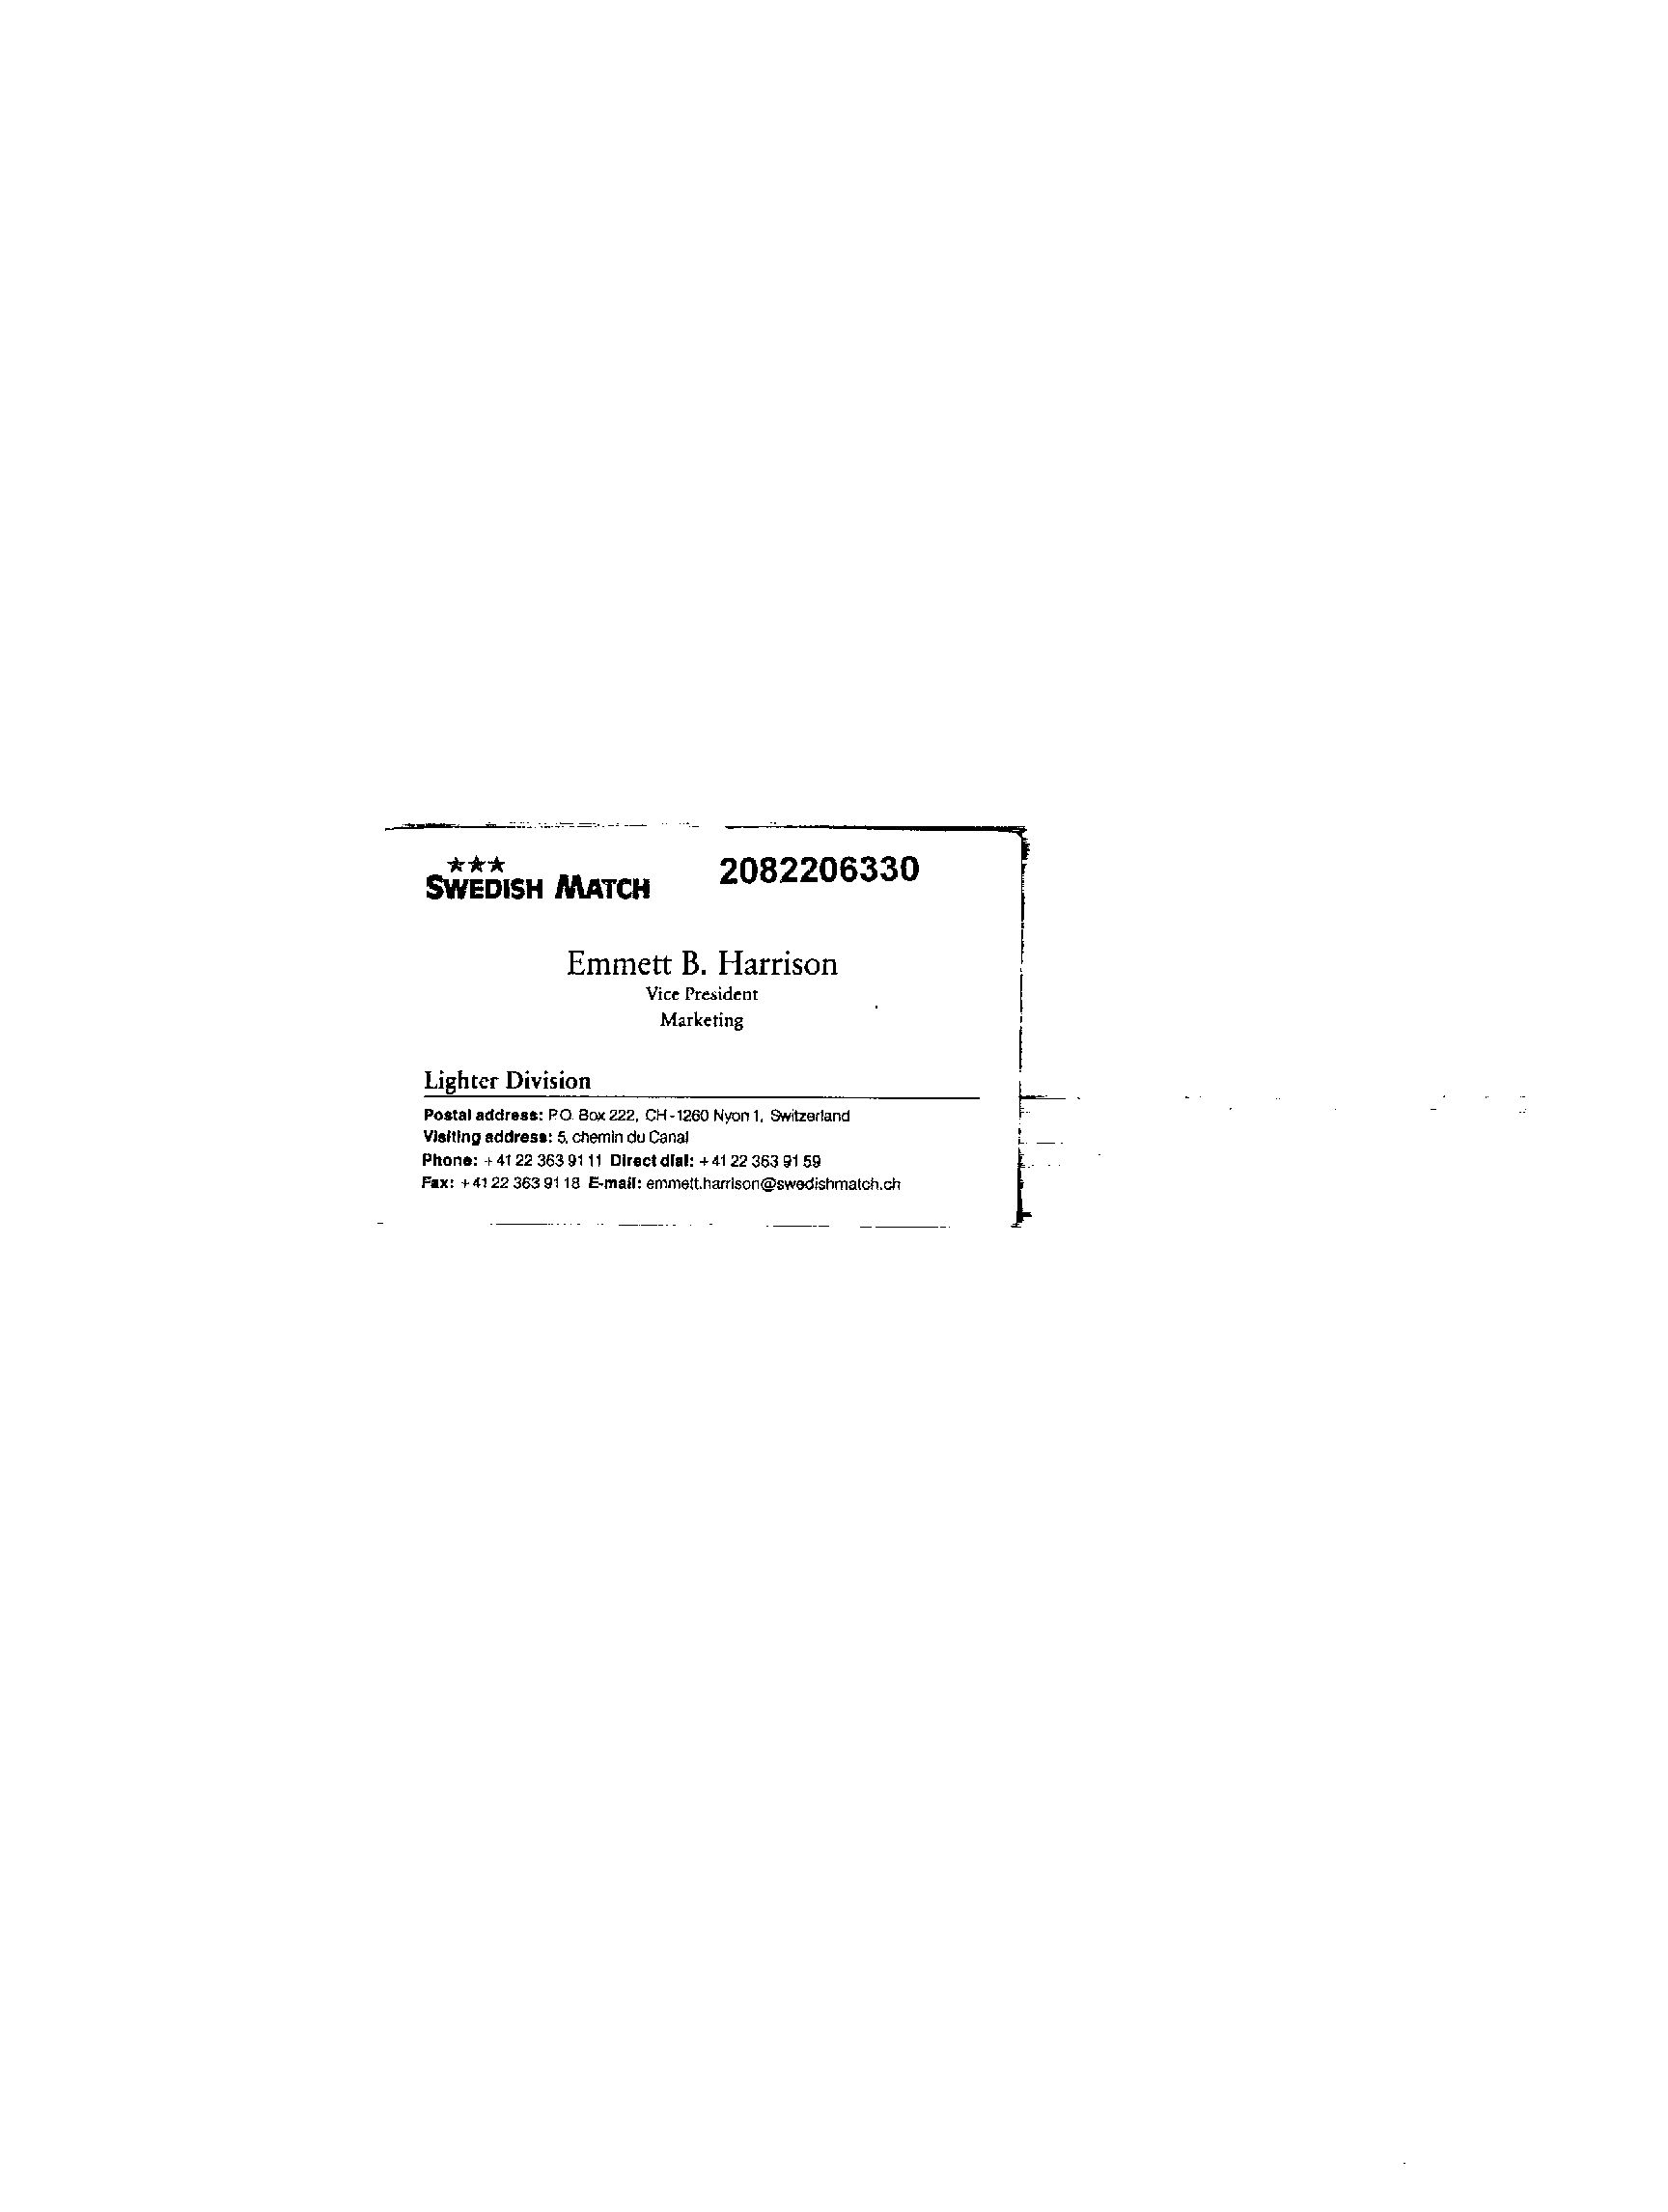

In [33]:
# load image to test on
image = Image.open(test_paths[6])
if image.mode != "RGB":
    image = image.convert("RGB")

image

In [34]:

model_save.eval()

# prepare image for the model
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model_save(pixel_values)
  logits = outputs.logits


In [35]:
# turn into probabilities by applying sigmoid
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
#print(probs)
# select the probabilities > a certain threshold (e.g. 50%) as predicted
predictions = np.zeros(probs.shape)
#print(predictions)
predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
#print(predictions)
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['note']


## Evaluation

In [36]:

def pred_pre(model_save, root,processor):
  root = root
  processor = processor
  true_labels=[]
  predicted_labels=[]
  

  for idx in range(len(root)):
    # get image
    image_path = root[idx]
    image = cv2.imread(image_path)
    #print(idx)
    try:
      label = image_path.split(os.path.sep)[-2].split(' ')
      #print(image_path)
      # get labels
      labels2=label2id[label[0]]

      image = Image.open(image_path)
      if image.mode != "RGB":
        image = image.convert("RGB")

      # prepare image for the model
      pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

      # forward pass
      with torch.no_grad():
        outputs = model_save(pixel_values)
        logits = outputs.logits


      # turn into probabilities by applying sigmoid
      sigmoid = torch.nn.Sigmoid()
      probs = sigmoid(logits.squeeze().cpu())

      # select the probabilities > a certain threshold (e.g. 50%) as predicted
      predictions = np.zeros(probs.shape)

      predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names

      predicted_label = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]

      predicted_labels2=label2id[predicted_label[0]]

      predicted_labels.append(predicted_labels2)
      true_labels.append(labels2)

    except ValueError as ve:
      print("ve")

    except IndexError as ie:
      predicted_labels.append(1)
      true_labels.append(labels2)


  return predicted_labels,true_labels




In [37]:

paths_test = []
path_to_subset = '/kaggle/input/document-dataset-400/test'
for folder in os.listdir(path_to_subset):

    for image in os.listdir(os.path.join(path_to_subset, folder)):
        path_to_image = os.path.join(path_to_subset, folder, image)

        #check image none or not none
        img = cv2.imread(path_to_image)
        if img is not None:
          paths_test.append( path_to_image)

In [38]:


ppredicted_labels,true_labels = pred_pre(model_save=model_save,root=paths_test,processor=processor)

In [39]:
print(len(ppredicted_labels))
print(len(true_labels))

119
119


### confusion metrix

In [40]:
list(label2id.keys())

['advertisement', 'email', 'form', 'invoice', 'note']

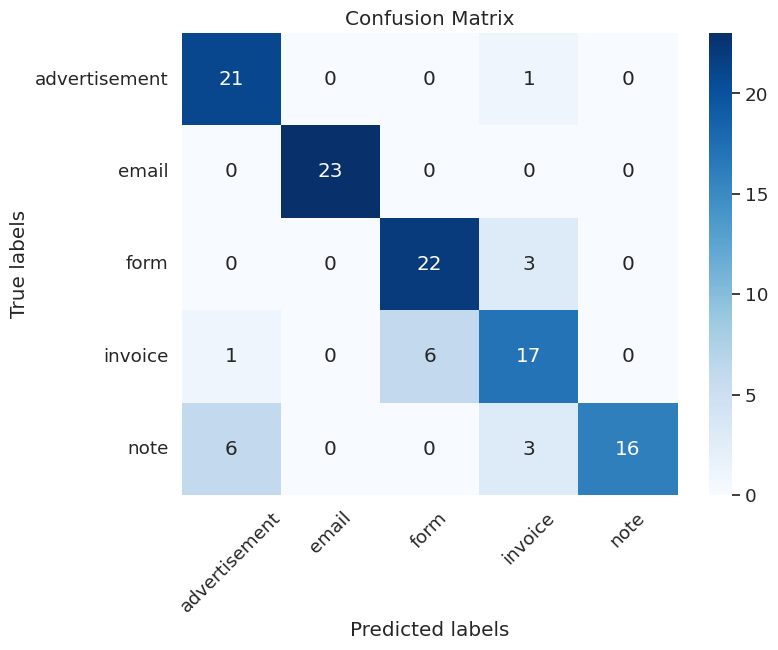

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'true_labels' are the true labels and 'predicted_labels' are the predicted labels
#true_labels = [0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
true_labels=true_labels
#predicted_labels = [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
predicted_labels=ppredicted_labels

# Define class labels
class_names = list(label2id.keys())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and colorbar
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

### Accuracy report

In [42]:
#accuracy report
from sklearn.metrics import accuracy_score, classification_report

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Accuracy: 0.8319327731092437
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        22
           1       1.00      1.00      1.00        23
           2       0.79      0.88      0.83        25
           3       0.71      0.71      0.71        24
           4       1.00      0.64      0.78        25

    accuracy                           0.83       119
   macro avg       0.85      0.84      0.83       119
weighted avg       0.85      0.83      0.83       119

